#### Exercise 3.2: Fine-tuning a CLIP Model (harder)

Use a (small) CLIP model like [`openai/clip-vit-base-patch16`](https://huggingface.co/openai/clip-vit-base-patch16) and evaluate its zero-shot performance on a small image classification dataset like ImageNette or TinyImageNet. Fine-tune (using a parameter-efficient method!) the CLIP model to see how much improvement you can squeeze out of it.

**Note**: There are several ways to adapt the CLIP model; you could fine-tune the image encoder, the text encoder, or both. Or, you could experiment with prompt learning.

**Tip**: CLIP probably already works very well on ImageNet and ImageNet-like images. For extra fun, look for an image classification dataset with different image types (e.g. *sketches*).

# CoOp
leggendo la richiesta sopra mi sono subito interessato all prompt learaning, in particolare al metodo [`CoOp`](https://arxiv.org/pdf/2109.01134) ho iniziato verificando come il modello genera le text features. Ho confrontato le embedding testuali ottenute in modo standard con quelle calcolate manualmente, ricostruendo passo passo l'intero flusso: partendo dagli embedding di token e posizione, passando per l'encoder transformer con la casual attention mask, applicando la layer norm finale e selezionando il token [EOT], fino alla proiezione lineare conclusiva. Il confronto ha mostrato che le text features manuali sono identiche a quelle standard, così come i logits ottenuti dal prodotto scalare con le image features. Questa verifica è fondamentale per poter in seguito sostituire gli embedding statici con quelli apprendibili, come previsto dal metodo CoOp.

In [1]:
import torch
from PIL import Image
import requests
from transformers import CLIPProcessor, CLIPModel
from transformers.modeling_attn_mask_utils import _create_4d_causal_attention_mask

model_name = "openai/clip-vit-base-patch16"
model = CLIPModel.from_pretrained(model_name).eval()
processor = CLIPProcessor.from_pretrained(model_name)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)


texts = ["a photo of a cat", "a photo of a dog"]
inputs = processor(text=texts, return_tensors="pt", padding=True).to(device)
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

input_ids = inputs['input_ids']


with torch.no_grad():
    
    outputs = model.text_model(**inputs, output_hidden_states=True)
    standard_text_features = model.get_text_features(input_ids=input_ids)


    embeddings_module = model.text_model.embeddings
    token_embeds = embeddings_module.token_embedding(input_ids)
    position_ids = torch.arange(input_ids.shape[1], device=device).unsqueeze(0)
    positional_embeds = embeddings_module.position_embedding(position_ids)
    manual_initial_embeddings = token_embeds + positional_embeds
    
    print("gli embending sono uguali :", manual_initial_embeddings.equal(outputs.hidden_states[0]))
   
    causal_attention_mask = _create_4d_causal_attention_mask(
        input_ids.size(), manual_initial_embeddings.dtype, device=device
    )  
    encoder_outputs = model.text_model.encoder(inputs_embeds=manual_initial_embeddings, output_hidden_states=True , causal_attention_mask=causal_attention_mask)
    i = 0 
    for hidden in outputs.hidden_states:
        if encoder_outputs.last_hidden_state.equal(hidden):
            print("l'uscita dell'encoder è uguale :", i)
        i+=1
        
    standard_text_features = model.get_text_features(input_ids=input_ids, output_hidden_states=True )
  
    last_hidden_state = encoder_outputs.last_hidden_state
    normed_hidden_state = model.text_model.final_layer_norm(last_hidden_state)
    eot_token_positions = torch.argmax(input_ids, dim=-1)
    pooled_output = normed_hidden_state[torch.arange(normed_hidden_state.shape[0], device=device), eot_token_positions]
    manual_text_features = model.text_projection(pooled_output)
    print("features sono uguali :",standard_text_features.equal(manual_text_features))
   
   
    image_inputs = processor(images=image, return_tensors="pt").to(device)
    image_features = model.get_image_features(**image_inputs)
    
    image_features_norm = image_features / image_features.norm(p=2, dim=-1, keepdim=True)
    logit_scale = model.logit_scale.exp()
    
    text_features_norm_man = manual_text_features / manual_text_features.norm(p=2, dim=-1, keepdim=True)
    logits_manual = logit_scale * image_features_norm @ text_features_norm_man.t()

    
     
    inputs_image_text = processor(text=texts, images=image, return_tensors="pt", padding=True).to(device)
    standard_outputs = model(**inputs_image_text)
    logits_standard = standard_outputs.logits_per_image
    probs_standard = logits_standard.softmax(dim=-1)
        
    print("--- VERIFICA DEI RISULTATI FINALI (LOGITS) ---")
    print("Logits calcolati con metodo STANDARD:", logits_standard.cpu().numpy())
    print("Logits calcolati con metodo MANUALE: ", logits_manual.cpu().numpy())
    
   
   

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


gli embending sono uguali : True
l'uscita dell'encoder è uguale : 12
features sono uguali : True
--- VERIFICA DEI RISULTATI FINALI (LOGITS) ---
Logits calcolati con metodo STANDARD: [[22.73867  15.661786]]
Logits calcolati con metodo MANUALE:  [[22.738672 15.661789]]


# Fine-tuning CLIP con CoOp
definiamo un nuovo modello ovvero CLIP con il CoOp



In [2]:
from transformers import CLIPProcessor, CLIPModel, CLIPTokenizer
from transformers.modeling_attn_mask_utils import _create_4d_causal_attention_mask
import torch
import torch.nn as nn
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_NAME = "openai/clip-vit-base-patch16"

class CoOpCLIP(nn.Module):
    def __init__(self, class_names, clip_model, m_ctx=16):
        super().__init__()
        self.class_names = class_names
        self.n_classes = len(class_names)
        self.n_ctx = m_ctx
        self.clip_model = clip_model
        embedding_dim = clip_model.text_model.config.hidden_size
        ctx_vectors = torch.empty(self.n_ctx, embedding_dim, device=DEVICE)
        nn.init.normal_(ctx_vectors, std=0.02)
        self.context_vectors = nn.Parameter(ctx_vectors)
        self.tokenizer = CLIPTokenizer.from_pretrained(MODEL_NAME)
        tokenized_classes = self.tokenizer([c for c in class_names], padding = True, return_tensors="pt")
        self.class_token_ids = tokenized_classes.input_ids.to(DEVICE)
        for param in self.clip_model.parameters():
            param.requires_grad = False

    def construct_prompts(self):
        embedding_layer = self.clip_model.text_model.embeddings.token_embedding
        prefix_embeddings = embedding_layer(self.class_token_ids[:, :1])
        class_embeddings = embedding_layer(self.class_token_ids[:, 1:])
        context_embeddings = self.context_vectors.unsqueeze(0).expand(self.n_classes, -1, -1)
        prompt_embeddings = torch.cat([prefix_embeddings, context_embeddings, class_embeddings], dim=1)
        return prompt_embeddings

    def forward(self, image):
       

        prompt_embeds = self.construct_prompts()
        
        text_encoder = self.clip_model.text_model
        # print(prompt_embeds.shape, prompt_embeds.dtype, prompt_embeds.device)
        pos_ids = torch.arange(prompt_embeds.size(1), device=DEVICE).unsqueeze(0)
        positional_embeddings = text_encoder.embeddings.position_embedding(pos_ids)
        inputs_embeds = prompt_embeds + positional_embeddings
        
        input_shape = prompt_embeds.shape[:2]
        
        # per utilizzare correttamente l'encoder è fondamentale creare una maschera di attenzione causale ho seguito l'implementazione a 
        # https://github.com/huggingface/transformers/blob/main/src/transformers/models/clip/modeling_clip.py#L620 
        # riga 620 gli ho passato la dimensione degli input_ids con anche gli embedding aggiunti  [102 , 1+16+7] prefisso context class ed end 
        causal_attention_mask = _create_4d_causal_attention_mask(
            input_shape, inputs_embeds.dtype, device=DEVICE
        )

        encoder_outputs = text_encoder.encoder(
            inputs_embeds=inputs_embeds,
            causal_attention_mask=causal_attention_mask
        )
        last_hidden_state = encoder_outputs.last_hidden_state

        eos_positions = self.class_token_ids.argmax(dim=-1) 
        # print(eos_positions)
        final_token_indices = self.n_ctx + (eos_positions)
        #https://github.com/huggingface/transformers/blob/main/src/transformers/models/clip/modeling_clip.py#L1023 
        #ripreso da 1023 a 1035
        pooled_output = last_hidden_state[torch.arange(self.n_classes), final_token_indices]
 
        pooled_output = text_encoder.final_layer_norm(pooled_output)
        
        
        
        image_features = self.clip_model.get_image_features(pixel_values=image)
        image_features = image_features / image_features.norm(p=2,dim=-1, keepdim=True)
        
        text_features = self.clip_model.text_projection(pooled_output)
        text_features = text_features / text_features.norm(p=2, dim=-1, keepdim=True) # implementazione in una riga di vector norm 
        
        logit_scale = self.clip_model.logit_scale.exp()
       
        logits = logit_scale * image_features @ text_features.t()
        #al posto di mat mul ho usato @ 

        return logits



# few shot learning
definamo la funzione per la creazione di un dataset few shot

In [3]:
from torch.utils.data import DataLoader, Dataset
class FewShotDataset(Dataset):
    def __init__(self, samples):
        self.samples = samples
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, idx):
        return self.samples[idx]
    
    
def create_few_shot_split(full_dataset, num_shots):
    if num_shots > 10:
        raise ValueError("Il numero di campioni per classe deve essere <= 10")
    
    samples_per_class = {i: [] for i in range(len(class_names))}
    for idx, (_, label) in enumerate(full_dataset):
        samples_per_class[label].append(idx)
    few_shot_samples = []
    #print(samples_per_class)
    for label, indices in samples_per_class.items():
        selected_indices = random.sample(indices, min(num_shots, len(indices)))
        for idx in selected_indices:
            few_shot_samples.append(full_dataset[idx])
    return FewShotDataset(few_shot_samples)


# Accuracy
definamo una la funzione evaluate per calcolare l'accuratezza del Clip base (Zero Shot) e del CoOp dato che hanno interfaccie diverse usato un parametro zero shot per distinguere i due casi 

In [4]:
import evaluate as hfevaluate
from tqdm.notebook import tqdm
@torch.no_grad()
def evaluate(model, dataloader, processor, class_names, is_zeroshot=False):
    model.eval()
    accuracy_metric = hfevaluate.load("accuracy")
    if is_zeroshot:
        text_inputs = processor(
            text=[f"a photo of a {c}, a type of flower." for c in class_names],  #da fig 1 pag 2 si osserva che si ottiene risultati migliori 
            return_tensors="pt", padding=True
        ).to(DEVICE)
        text_features = model.get_text_features(**text_inputs)
        text_features /= text_features.norm(p=2, dim=-1, keepdim=True)

    pbar = tqdm(dataloader, desc="Valutazione")
    for images, labels in pbar:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        if is_zeroshot:
            image_features = model.get_image_features(pixel_values=images)
            image_features /= image_features.norm(p=2, dim=-1, keepdim=True)
            logits = model.logit_scale.exp() * image_features @ text_features.t()
        else: 
            logits = model(images)

        predictions = torch.argmax(logits, dim=-1)
        
        accuracy_metric.add_batch(predictions=predictions, references=labels)
    results = accuracy_metric.compute()
    return results['accuracy'] * 100

# Train and Evaluate
implemento la logica per addestrare e valutare il modello con CoOp ho scelto come dataset flower102 ogni 10 epoche valuto sul validation set e salvo il modello migliore, alla fine valuto sul test set e calcolo la differenza con il modello zero shot. 


In [5]:
import numpy as np
import random
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import InterpolationMode, Resize, CenterCrop, ToTensor, Normalize, Compose
from torchvision.datasets import Flowers102
import os
random.seed(10)
SHOTS = [1, 2, 4, 8]
M_CONTEXT_VECTORS = 16
EPOCHS = [50,100,100,200] 
BATCH_SIZE = 4
LEARNING_RATE = 2e-3
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_NAME = "openai/clip-vit-base-patch16"

processor = CLIPProcessor.from_pretrained(MODEL_NAME)
if not os.path.exists("best_models"):
    os.makedirs("best_models")


#presa da https://github.com/openai/CLIP/blob/dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1/clip/clip.py#L79      
def _convert_image_to_rgb(image):
    return image.convert("RGB")
preprocess = Compose([
        Resize(224, interpolation= InterpolationMode.BICUBIC),
        CenterCrop(224),
        _convert_image_to_rgb,
        ToTensor(),
        Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
])




full_train_dataset = Flowers102(root="data", split="train", download=True, transform=preprocess)
test_dataset = Flowers102(root="data", split="test", download=True, transform=preprocess)
validation_dataset = Flowers102(root="data", split="val", download=True, transform=preprocess)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False, pin_memory=True)

base_clip_model = CLIPModel.from_pretrained(MODEL_NAME).to(DEVICE)

print(f"Caricato il dataset Flowers102 con {len(full_train_dataset)} immagini di addestramento, {len(test_dataset)} immagini di test e {len(validation_dataset)} immagini di validazione.")

class_names = full_train_dataset.classes



def train_one_epoch(model, dataloader, optimizer, scheduler):
    model.train()
    total_loss = 0
    for images, labels in dataloader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(images)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        pbar.set_postfix({"loss": loss.item()})
    scheduler.step()
    return total_loss / len(dataloader)






print("\n--- Calcolo della Baseline Zero-Shot CLIP ---")
zeroshot_accuracy = evaluate(base_clip_model, test_loader, processor, class_names, is_zeroshot=True)
print(f"Accuracy Zero-Shot CLIP: {zeroshot_accuracy:.2f}%")
print("-" * 50)



    
    
    
results = {}    
for i, shot in enumerate(SHOTS):
    print(f"\n--- Addestramento CoOp con {shot} shot per classe ---")
    train_dataset_few_shot = create_few_shot_split(full_train_dataset, shot)
    train_loader_few_shot = DataLoader(train_dataset_few_shot, batch_size=BATCH_SIZE, shuffle=True , pin_memory=True)

    
    coop_model = CoOpCLIP(class_names, base_clip_model, m_ctx=M_CONTEXT_VECTORS).to(DEVICE)
    
    optimizer = torch.optim.SGD(coop_model.parameters(), lr=LEARNING_RATE)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS[i])
    
    
    best_val_accuracy = 0.0
    best_model_path = f"best_models/best_coop_{shot}-shot.pth"
    
    
    pbar = tqdm(range(EPOCHS[i]), desc=f"Addestramento CoOp ({shot}-shot)")
    
    for epoch in pbar:
        train_loss = train_one_epoch(coop_model, train_loader_few_shot, optimizer, scheduler)
        if (epoch+1) % 10 == 0:
            coop_model.eval()
            with torch.no_grad():
                current_val_accuracy = evaluate(coop_model, validation_loader, processor, class_names)
            print(f"Epoch {epoch+1}/{EPOCHS[i]}, Loss: {train_loss:.4f}")
            print(f"Validation Accuracy: {current_val_accuracy:.2f}%")
            if current_val_accuracy > best_val_accuracy:
                best_val_accuracy = current_val_accuracy
                torch.save(coop_model.state_dict(), best_model_path)
                print(f" Nuovo modello migliore salvato in '{best_model_path}' con accuracy {best_val_accuracy:.2f}%")
            
            coop_model.train()
    
    
    
    coop_accuracy = evaluate(coop_model, test_loader, processor, class_names)
    results[shot] = coop_accuracy
    
    print(f"Accuracy CoOp ({shot}-shot) sul TEST SET: {coop_accuracy:.2f}%")
    print(f"Differenza vs Zero-Shot: {coop_accuracy - zeroshot_accuracy:+.2f}%")
    print("-" * 50)




100%|██████████| 345M/345M [00:28<00:00, 12.1MB/s] 
100%|██████████| 502/502 [00:00<00:00, 504kB/s]
100%|██████████| 15.0k/15.0k [00:00<00:00, 15.0MB/s]


Caricato il dataset Flowers102 con 1020 immagini di addestramento, 6149 immagini di test e 1020 immagini di validazione.

--- Calcolo della Baseline Zero-Shot CLIP ---


Valutazione:   0%|          | 0/193 [00:00<?, ?it/s]

Accuracy Zero-Shot CLIP: 71.30%
--------------------------------------------------

--- Addestramento CoOp con 1 shot per classe ---


Addestramento CoOp (1-shot):   0%|          | 0/50 [00:00<?, ?it/s]

Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 10/50, Loss: 0.4364
Validation Accuracy: 78.63%
 Nuovo modello migliore salvato in 'best_models/best_coop_1-shot.pth' con accuracy 78.63%


Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 20/50, Loss: 0.0913
Validation Accuracy: 79.41%
 Nuovo modello migliore salvato in 'best_models/best_coop_1-shot.pth' con accuracy 79.41%


Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 30/50, Loss: 0.0520
Validation Accuracy: 79.31%


Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 40/50, Loss: 0.0415
Validation Accuracy: 78.73%


Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 50/50, Loss: 0.0393
Validation Accuracy: 78.43%


Valutazione:   0%|          | 0/193 [00:00<?, ?it/s]

Accuracy CoOp (1-shot) sul TEST SET: 77.69%
Differenza vs Zero-Shot: +6.39%
--------------------------------------------------

--- Addestramento CoOp con 2 shot per classe ---


Addestramento CoOp (2-shot):   0%|          | 0/100 [00:00<?, ?it/s]

Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 10/100, Loss: 0.2669
Validation Accuracy: 87.25%
 Nuovo modello migliore salvato in 'best_models/best_coop_2-shot.pth' con accuracy 87.25%


Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 20/100, Loss: 0.0503
Validation Accuracy: 88.33%
 Nuovo modello migliore salvato in 'best_models/best_coop_2-shot.pth' con accuracy 88.33%


Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 30/100, Loss: 0.0281
Validation Accuracy: 88.24%


Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 40/100, Loss: 0.0204
Validation Accuracy: 88.73%
 Nuovo modello migliore salvato in 'best_models/best_coop_2-shot.pth' con accuracy 88.73%


Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 50/100, Loss: 0.0166
Validation Accuracy: 88.92%
 Nuovo modello migliore salvato in 'best_models/best_coop_2-shot.pth' con accuracy 88.92%


Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 60/100, Loss: 0.0145
Validation Accuracy: 88.73%


Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 70/100, Loss: 0.0133
Validation Accuracy: 88.63%


Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 80/100, Loss: 0.0127
Validation Accuracy: 88.63%


Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 90/100, Loss: 0.0124
Validation Accuracy: 88.73%


Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 100/100, Loss: 0.0123
Validation Accuracy: 88.73%


Valutazione:   0%|          | 0/193 [00:00<?, ?it/s]

Accuracy CoOp (2-shot) sul TEST SET: 89.40%
Differenza vs Zero-Shot: +18.10%
--------------------------------------------------

--- Addestramento CoOp con 4 shot per classe ---


Addestramento CoOp (4-shot):   0%|          | 0/100 [00:00<?, ?it/s]

Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 10/100, Loss: 0.1667
Validation Accuracy: 90.69%
 Nuovo modello migliore salvato in 'best_models/best_coop_4-shot.pth' con accuracy 90.69%


Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 20/100, Loss: 0.0489
Validation Accuracy: 90.39%


Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 30/100, Loss: 0.0295
Validation Accuracy: 90.98%
 Nuovo modello migliore salvato in 'best_models/best_coop_4-shot.pth' con accuracy 90.98%


Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 40/100, Loss: 0.0221
Validation Accuracy: 91.76%
 Nuovo modello migliore salvato in 'best_models/best_coop_4-shot.pth' con accuracy 91.76%


Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 50/100, Loss: 0.0183
Validation Accuracy: 91.76%


Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 60/100, Loss: 0.0161
Validation Accuracy: 91.86%
 Nuovo modello migliore salvato in 'best_models/best_coop_4-shot.pth' con accuracy 91.86%


Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 70/100, Loss: 0.0147
Validation Accuracy: 92.16%
 Nuovo modello migliore salvato in 'best_models/best_coop_4-shot.pth' con accuracy 92.16%


Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 80/100, Loss: 0.0140
Validation Accuracy: 92.25%
 Nuovo modello migliore salvato in 'best_models/best_coop_4-shot.pth' con accuracy 92.25%


Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 90/100, Loss: 0.0136
Validation Accuracy: 92.25%


Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 100/100, Loss: 0.0136
Validation Accuracy: 92.25%


Valutazione:   0%|          | 0/193 [00:00<?, ?it/s]

Accuracy CoOp (4-shot) sul TEST SET: 90.97%
Differenza vs Zero-Shot: +19.68%
--------------------------------------------------

--- Addestramento CoOp con 8 shot per classe ---


Addestramento CoOp (8-shot):   0%|          | 0/200 [00:00<?, ?it/s]

Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 10/200, Loss: 0.1196
Validation Accuracy: 93.53%
 Nuovo modello migliore salvato in 'best_models/best_coop_8-shot.pth' con accuracy 93.53%


Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 20/200, Loss: 0.0505
Validation Accuracy: 93.73%
 Nuovo modello migliore salvato in 'best_models/best_coop_8-shot.pth' con accuracy 93.73%


Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 30/200, Loss: 0.0304
Validation Accuracy: 95.29%
 Nuovo modello migliore salvato in 'best_models/best_coop_8-shot.pth' con accuracy 95.29%


Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 40/200, Loss: 0.0229
Validation Accuracy: 94.90%


Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 50/200, Loss: 0.0182
Validation Accuracy: 94.90%


Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 60/200, Loss: 0.0150
Validation Accuracy: 95.10%


Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 70/200, Loss: 0.0129
Validation Accuracy: 95.59%
 Nuovo modello migliore salvato in 'best_models/best_coop_8-shot.pth' con accuracy 95.59%


Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 80/200, Loss: 0.0113
Validation Accuracy: 95.59%


Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 90/200, Loss: 0.0103
Validation Accuracy: 95.88%
 Nuovo modello migliore salvato in 'best_models/best_coop_8-shot.pth' con accuracy 95.88%


Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 100/200, Loss: 0.0094
Validation Accuracy: 96.18%
 Nuovo modello migliore salvato in 'best_models/best_coop_8-shot.pth' con accuracy 96.18%


Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 110/200, Loss: 0.0087
Validation Accuracy: 95.88%


Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 120/200, Loss: 0.0082
Validation Accuracy: 95.98%


Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 130/200, Loss: 0.0078
Validation Accuracy: 96.08%


Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 140/200, Loss: 0.0075
Validation Accuracy: 95.98%


Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 150/200, Loss: 0.0073
Validation Accuracy: 95.88%


Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 160/200, Loss: 0.0071
Validation Accuracy: 95.88%


Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 170/200, Loss: 0.0070
Validation Accuracy: 95.88%


Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 180/200, Loss: 0.0069
Validation Accuracy: 95.88%


Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 190/200, Loss: 0.0069
Validation Accuracy: 95.88%


Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 200/200, Loss: 0.0069
Validation Accuracy: 95.88%


Valutazione:   0%|          | 0/193 [00:00<?, ?it/s]

Accuracy CoOp (8-shot) sul TEST SET: 95.14%
Differenza vs Zero-Shot: +23.84%
--------------------------------------------------


Valutazione:   0%|          | 0/193 [00:00<?, ?it/s]


===== RIEPILOGO DEI RISULTATI =====
Baseline Zero-Shot CLIP: 71.30%
-----------------------------------
Shots	| CoOp Accuracy	| Miglioramento
-----------------------------------


Valutazione:   0%|          | 0/193 [00:00<?, ?it/s]

1	| 77.52%		| +6.23%


Valutazione:   0%|          | 0/193 [00:00<?, ?it/s]

2	| 89.35%		| +18.05%


Valutazione:   0%|          | 0/193 [00:00<?, ?it/s]

4	| 90.97%		| +19.68%


Valutazione:   0%|          | 0/193 [00:00<?, ?it/s]

8	| 95.35%		| +24.05%


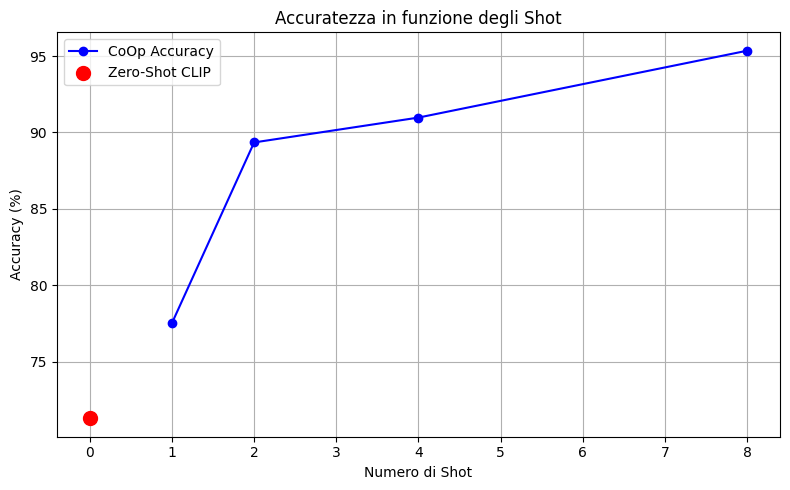

In [6]:
import torch
import matplotlib.pyplot as plt
from torchvision.datasets import Flowers102
from transformers import  CLIPModel, CLIPProcessor
from torchvision.transforms import InterpolationMode, Resize, CenterCrop, ToTensor, Normalize, Compose
from torch.utils.data import DataLoader

M_CONTEXT_VECTORS = 16
SHOTS = [1, 2, 4, 8]
def _convert_image_to_rgb(image):
    return image.convert("RGB")
preprocess = Compose([
    Resize(224, interpolation=InterpolationMode.BICUBIC),
    CenterCrop(224),
    _convert_image_to_rgb,
    ToTensor(),
    Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
])
processor = CLIPProcessor.from_pretrained(MODEL_NAME)
full_train_dataset = Flowers102(root="data", split="train", download=True, transform=preprocess)
test_dataset = Flowers102(root="data", split="test", download=True, transform=preprocess)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)
class_names = full_train_dataset.classes
base_clip_model = CLIPModel.from_pretrained(MODEL_NAME).to(DEVICE)
zeroshot_accuracy = evaluate(base_clip_model, test_loader, processor, class_names, is_zeroshot=True)





print("\n===== RIEPILOGO DEI RISULTATI =====")
print(f"Baseline Zero-Shot CLIP: {zeroshot_accuracy:.2f}%") 
print("-" * 35)
print("Shots\t| CoOp Accuracy\t| Miglioramento")
print("-" * 35)
results = {}
for shot in SHOTS:
    m = CoOpCLIP(class_names, base_clip_model, m_ctx=M_CONTEXT_VECTORS)
    m.load_state_dict(torch.load(f"best_models/best_coop_{shot}-shot.pth"))
    m.to(DEVICE)
    m.eval()
    with torch.no_grad():
        acc = evaluate(m, test_loader, processor, class_names)
    improvement = acc - zeroshot_accuracy
    results[shot] = acc
    print(f"{shot}\t| {acc:.2f}%\t\t| {improvement:+.2f}%")
print("=" * 35)



shots =  sorted(results.keys())
accuracies =  [results[shot] for shot in sorted(results.keys())]
plt.figure(figsize=(8, 5))

plt.plot(shots, accuracies, marker='o', linestyle='-', color='blue', label='CoOp Accuracy')
plt.scatter(0, zeroshot_accuracy, color='red', s=100, label='Zero-Shot CLIP', zorder=5)

plt.title("Accuratezza in funzione degli Shot")
plt.xlabel("Numero di Shot")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()  